# Laboratorio 3 - Parte 1 

### Modelos de mezclas de funciones Gausianas y k-means

### 2019-II

#### Profesor: Julián D. Arias Londoño
#### julian.ariasl@udea.edu.co


## Guía del laboratorio

En este archivo va a encontrar tanto celdas de código cómo celdas de texto con las instrucciones para desarrollar el laboratorio.

Lea atentamente las instrucciones entregadas en las celdas de texto correspondientes y proceda con la solución de las preguntas planteadas.

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

#### Primer integrante:  Santiago Gaviria Zapata
#### Segundo integrante: Jorge Hiler Ricardo

In [19]:
#Algunas advertencias que queremos evitar
import warnings
warnings.filterwarnings("always") 

%matplotlib inline
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture as gmm


## Ejercicio 1: Contextualización del problema

A continuación se leen los datos de un problema de clasificación. El problema corresponde a la clasificación de dígitos escritos a mano. Usaremos únicamente 4 de las 10 clases disponibles. Los datos fueron preprocesados para reducir el número de características. La técnica usada será analizada más adelante en el curso.

In [20]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
digits = load_digits(n_class=4)

#--------- preprocesamiento--------------------
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)

#---------- Datos a usar ----------------------
X = data
Y = digits.target

Un vistazo a la base de datos

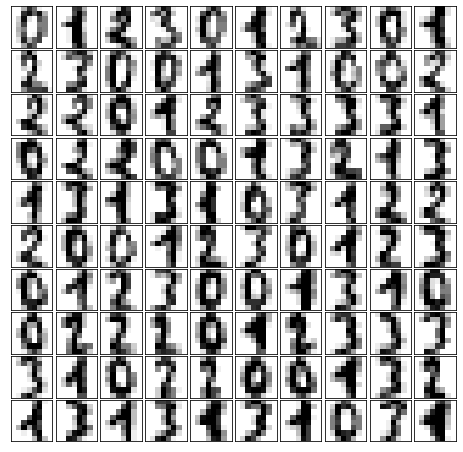

In [21]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Responda:

1.1 ¿Cuántas muestras por clase tiene la base de datos?:

In [32]:
print('Respectivamente:', cantXClase)

Respectivamente: [178 182 177 183]


1.2 ¿Cuántas características tiene cada muestra?


In [33]:
print(np.size(X,1))

39


1.2 Teniendo en cuenta el tipo de problema y el número de muestras por clase, ¿qué metodología de validación debería usar?¿Porqué?:

La forma habitual es utilizar un procedimiento de validación cruzada para hayar el mejor valor de  𝑀 , similar a como debe hacerse para encontrar el mejor valor de  𝐾  en el modelo de K-vécinos más cercanos.

## Ejercicio 2: Completar el código

En la siguiente celda defina una función que tome como entradas una matriz $X$ y una matriz $Y$, entrene un modelo GMM  (Modelo de mezclas gaussianas) por cada clase y retorne el listado de modelos para cada clase. Debe consultar todo lo relacionado con la creación, entrenamiento y uso en predicción de este modelo usando la librería scikit-learn. Consultar aquí: http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html


Adicionalmente construya una función que use los modelos entrenados en la función anterior para hacer la clasificación de un conjunto nuevo de muestras.



In [69]:
features = np.size(X,1)
ni, cantXClase = np.unique(Y, return_counts=True)

def separateByClass(X,Y):
    x0 = np.zeros([cantXClase[0], features])
    x1 = np.zeros([cantXClase[1], features])
    x2 = np.zeros([cantXClase[2], features])
    x3 = np.zeros([cantXClase[3], features])

    for xi, yi in zip(X,Y):
        if(yi == 0):
            x0 = np.append(x0, xi)
        elif(yi == 1):
            x1 = np.append(x1, xi)
        elif(yi == 2):
            x2 = np.append(x2, xi)
        elif(yi == 3):
            x3 = np.append(x3, xi)
    
    return x0,x1,x2,x3
            
    #X: Matriz con las características
    #Y: Matriz con las clases
    #M: Número de componentes
    #tipo: Tipo de matriz de covarianza
            
def GMMClassifierTrain(X,Y,M,tipo):
    x0, x1, x2, x3 = separateByClass(X,Y)
    x0 = x0.reshape(-1,1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    x3 = x3.reshape(-1,1)
    gmm = GaussianMixture(n_components=M,covariance_type=tipo)
    GMMs = []
    GMMs.append(gmm.fit(x0))
    GMMs.append(gmm.fit(x1))
    GMMs.append(gmm.fit(x2))
    GMMs.append(gmm.fit(x3))
    return GMMs #Debe retornar un objeto que contenga todos los modelos entrenados

def GMMClassfierVal(GMMs,Xtest):
    c = len(GMMs)
    i = 0
    Yest = []
    for gmm in GMMs:
        Yest[i] = gmm.score_samples(Xtest)
        i += 1
    return Yest #Debe retornar un vector con las clases predichas para cada una de las muestras en Xtest, de acuerdo con los modelos almacenados en GMMs

## Ejercicio 3: Entrenamiento

En la siguiente celda se define una simulación para entrenar y validar un modelo usando los datos previamente cargados de lo digitos. Complete el código para usar como modelo de predicción un GMM.

Asegure que:


                                - Matriz de covarianza: diagonal 
                                - Numero de componentes: 3
                                - Eficiencia en validacion: 0.9555	
                                - Intervalo de confianza: 0.02297


In [70]:
import math
import numpy as np
from numpy import random, matlib
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

tipo = 'full'
#Validamos el modelo
def mainGMM(cov_index = 1,num_components=3):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        #(X,Y,M,tipo)
        gmms = GMMClassifierTrain(Xtrain, Ytrain, num_components, tipo)


        #Validación
        Ytrain_pred = GMMClassfierVal(gmms,Xtrain);
        Yest = GMMClassfierVal(gmms,Xtest);

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1
        
    print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
    return (np.mean(EficienciaTrain),np.mean(EficienciaVal))


mainGMM(1,3)
   

ValueError: Expected the input data X have 1 features, but got 39 features

## Ejercicio 4: Resultados

Una vez completado el código realice los experimentos necesarios para llenar la siguiente tabla:

In [10]:
import pandas as pd
import qgrid
randn = np.random.randn
df_types = pd.DataFrame({
    'Matriz de covarianza' : pd.Series(['Completa','Completa','Completa','Completa','Completa','Completa','Diagonal','Diagonal','Diagonal','Diagonal','Diagonal','Diagonal','Esférica','Esférica','Esférica','Esférica','Esférica','Esférica','Atada','Atada','Atada','Atada','Atada','Atada']),
    'Numero de componentes' : pd.Series([1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6])})
df_types["Eficiencia en validacion"] = ""
df_types["Intervalo de confianza"] = ""
df_types.set_index(['Matriz de covarianza','Numero de componentes'], inplace=True)
df_types["Eficiencia en validacion"][8] = "0.9555"
df_types["Intervalo de confianza"][8] = "0.02297"
#df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Ejecute la siguiente instrucción para dejar guardados en el notebook los resultados de las pruebas.


In [7]:
qgrid_widget.get_changed_df()

Eficiencia en validacion  \
Matriz de covarianza Numero de componentes                            
Completa             1                                                
                     2                                                
                     3                                                
                     4                                                
                     5                                                
                     6                                                
Diagonal             1                                                
                     2                                                
                     3                                       0.9555   
                     4                                                
                     5                                                
                     6                                                
Esférica             1                                                
                     2                                                
                     3                                                
                     4                                                
                     5                                                
                     6                                                
Atada                1                                                
                     2                                                
                     3                                                
                     4                                                
                     5                                                
                     6                                                

                                           Intervalo de confianza  
Matriz de covarianza Numero de componentes                         
Completa             1                                             
                     2                                             
                     3                                             
                     4                                             
                     5                                             
                     6                                             
Diagonal             1                                             
                     2                                             
                     3                                    0.02297  
                     4                                             
                     5                                             
                     6                                             
Esférica             1                                             
                     2                                             
                     3                                             
                     4                                             
                     5                                             
                     6                                             
Atada                1                                             
                     2                                             
                     3                                             
                     4                                             
                     5                                             
                     6

Responda

4.1 La tabla incluye un tipo de matriz de covarianza no visto en clase, Atada, ¿En qué consiste este tipo de matriz según la documentación en scikit-learn?:

4.2  ¿Qué método se utilizó para la incialización de los parámetros del modelo GMM?:

4.3 ¿El algoritmo EM presentó problemas de convergencia o colapso para alguna de las combinaciones de parámetros?

## Ejercicio 5

En la siguiente celda, utilice las muestras de la base de datos iris incluidos en la variable Xclustering. 
Lleve a cabo el agrupamiento de los datos usando el algoritmo k-means y el modelo GMM.

Consultar todo lo relacionado al llamado del método KMeans de la librería scikit-learn en el siguiente enlace: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. 


Realice el agrupamiento para 2 y 3 grupos y grafique los resultados del agrupamiento en cada caso (use colores para los puntos de acuerdo con el grupo asignado por el algoritmo de agrupamiento). Para el caso del GMM use una matriz de covarianza completa y una matriz diagonal. El resultado de este punto son 6 gráficas.

<function matplotlib.pyplot.show(*args, **kw)>

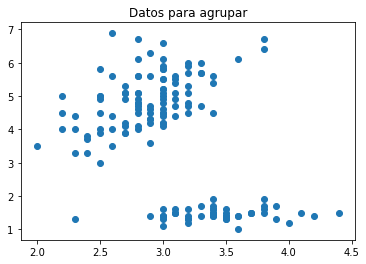

In [26]:
from sklearn.datasets import load_iris
data = load_iris()
X=data.data
Xclustering = X[:,1:3]
plt.scatter(Xclustering[:,0],Xclustering[:,1])
plt.title("Datos para agrupar")
plt.show

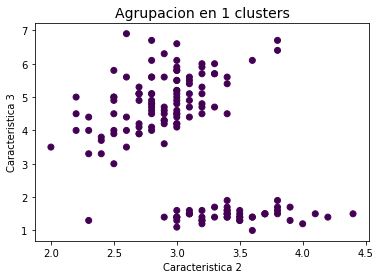

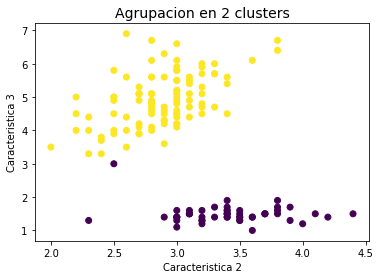

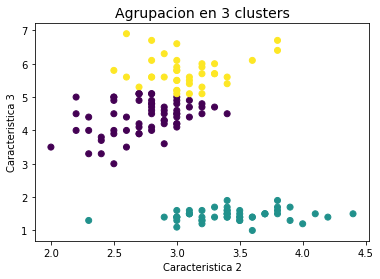

In [14]:
from sklearn.cluster import KMeans
for M in range(1,4):
    kmeans = KMeans(init='k-means++', n_clusters=M, n_init=1)
    kmeans.fit(Xclustering)
    Y = kmeans.predict(Xclustering)
    plt.figure()
    plt.title('Agrupacion en %d clusters' % M, fontsize=14)
    plt.xlabel('Caracteristica 2')
    plt.ylabel('Caracteristica 3')
    plt.scatter(Xclustering[:,0], Xclustering[:,1], c=Y);